# Subject 67 - Invariant Risk Minimization

## Introduction

This notebook presents essential results studied in the article **Invariant Risk Minimization** that can be found at https://arxiv.org/pdf/1907.02893.pdf.
Because most machine learning algorithms depend on the assumption that training and testing data are sampled independently from the same distribution, it is common practice to shuffle at random the training and testing sets. Nevertheless, this article suggests this is not always the best solution, in fact the origin of your data can contain some useful details and shuffling between all of them can discard some information. To adress this issue, the authors purpose another way of training model.

Before introducing this new idea, let's see first what can go wrong with traditional machine learning model through an example:

### The camel-cow example

Suppose you are working on an image classification task and you want to determine for each images whether it is a cow image or a camel one. Owing a set of images like the ones below you will surely train a CNN to deal with this task.
<table><tr>
<td> <img src="images/vache1.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="images/chameau1.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="images/vache2.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="images/chameau2.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

Unfortunately it is much probable that your neural network fails to classify such image :
<table><tr>
<td> <img src="images/vache_desert.jpeg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

The reason is that your CNN achieved a good training error minimization thanks to a cheat : classfying green and grassy landscape as cows and beige and aride one as camels. In fact, your model has exploited a spurious correlation (between lanscapes and types of animal) to classify your data. Imagine your data comes from two different sources or environnements : in the first one 90% of cows are in a green landscape, in the second one only 70%. Shuffling both of them will lose this information and perhaps misslead to the utilisation of landscape to determine if an animal is a cow. In keeping both environnement and study them disctinclty, you can notice that there is a strong (but spurious) link between grassy environnement and cow that should be discarded.

## The goal of Invariant Risk Minimization

### Definition of the study case 

The main objective of Invariant Risk Minimization (IRM) is to provide a new learning paradigm in estimating nonlinear, invariant, causal predictors from multiple training environments, which enable out-of-distribution (OOD) generalization.

In the following, we will consider datasets $D_e=\{(x_i^e,y_i^e)\}_{1\leq i\leq n_e}$ from different environnements $e\in \xi_{tr}$ where each pair describes the same random variables measured under different conditions.

The objective here is to use these environnements to learn a predictor $f$ such that $Y\approx f(X)$ and which performs well across a large set of unseen but related environments $\xi_{all} \supset \xi_{tr}$.

If we denote $R^e(f):=\mathbb{E}_{X^e,Y^e}[l(f(X^e),Y^e)]$ for a certain loss $l$, the goal to be minimized can be written as : $$$$
$$R^{OOD}(f) = max_{e\in \xi_{all}}R^e(f)$$

### A first toy example

We will define here a concrete and practical example which will be usefull all along this study. 

Let's consider the three following random variables defined on a set of some environnement $e\in\xi_{tr} $ as :
$$$$
$$X_1^e \sim \mathcal{N}(0,\,\sigma^{2}_e)$$
$$Y^e \sim X_1^e + \mathcal{N}(0,\,\sigma^{2}_e)$$
$$X_2^e \sim Y^e + \mathcal{N}(0,\,1)$$
$$$$
where $\xi_{all} $ denotes the set of all possible/existing environnement.
$$$$

According to you, what will happen if we decide to predict $Y$, knowing $X_1$ and $X_2$ ?

In [1]:
# Any idea ?



#### Question 1 : 
Define the previous variables on two different environnements (for example $\sigma=0.1$ and $10)$.
Generate a consequent number of samples.

In [21]:
# %load question1
import numpy as np

#Generate n samples under environnement sigma
def sample(sigma, n):
    X1 = np.random.normal(0,sigma,n).reshape(-1,1)
    Y = X1 + np.random.normal(0,sigma,n).reshape(-1,1)
    X2 = Y + np.random.normal(0,1,n).reshape(-1,1)
    return X1, X2, Y

n = 10000 # number of samples for each environnement 

sigma1 = 10 # variance for the environnement 1 noise 
sigma2 = 0.1 # variance for the environnement 2 noise 

X1e1, X2e1, Ye1 = sample(sigma1, n)
X1e2, X2e2, Ye2 = sample(sigma2, n)

$$$$
Just before pursuing this case, let's compute now some statistics about these random variables which will be useful later : (you can check these following results with your previous implementation)

$\sigma^2(X_1^e)=\sigma^{2}_e$,

$\sigma^2(Y^e)=2\sigma^{2}_e$,

$\sigma^2(X_2^e)=2\sigma^{2}_e+1$,

$\sigma(X_1^e,Y^e)=\sigma^{2}_e$,

$\sigma(X_2^e,Y^e)=2\sigma^{2}_e$,

$\sigma^2(X_1^e,X_2^e)=\sigma^{2}_e$
$$$$

In order to predict $Y$, we will consider the three different linear regressions : $Y^e=aX_1^e+c$, $Y^e=bX_2^e+c$ and $Y^e=aX_1^e+bX_2^e+c$ and realize each regression on two distinct environnements.

#### Question 2

Realize the three regressions on two different environnements. For each regression, compare the coefficients between both environnement.

In [139]:
# %load question2
from sklearn.linear_model import LinearRegression
import question1

def regressor(Y, X):
    lr = LinearRegression()
    lr.fit(X,Y)
    return lr.coef_

reg1_env1 = regressor(Ye1,X1e1)[0]
reg2_env1 = regressor(Ye1,X2e1)[0]
reg3_env1 = regressor(Ye1,np.concatenate([X1e1,X2e1], axis=1))[0]

reg1_env2 = regressor(Ye2,X1e2)[0]
reg2_env2 = regressor(Ye2,X2e2)[0]
reg3_env2 = regressor(Ye2,np.concatenate([X1e2,X2e2], axis=1))[0]
                      
print("By running such regressions (despite different environnements), one might naively expect to \nhave quite the same result for each pair of regressions on both environnement but this is not \nthe case. \nFor the first regression we obtain %f as coefficient on environnement 1 and %f \non environnement 2.\nFor the second regression we obtain %f as coefficient on environnement 1 and %f \non environnement 2.\nFor the third regression we obtain the couple (%f, %f) as coefficients on \nenvironnement 1 and (%f, %f) on environnement 2." % (reg1_env1, reg1_env2, reg2_env1, reg2_env2, reg3_env1[0], reg3_env1[1], reg3_env2[0], reg3_env2[1]))

By running such regressions (despite different environnements), one might naively expect to 
have quite the same result for each pair of regressions on both environnement but this is not 
the case. 
For the first regression we obtain 1.006497 as coefficient on environnement 1 and 0.992666 
on environnement 2.
For the second regression we obtain 0.996178 as coefficient on environnement 1 and 0.019661 
on environnement 2.
For the third regression we obtain the couple (0.011667, 0.990279) as coefficients on 
environnement 1 and (0.983004, 0.009805) on environnement 2.


### Explanation of the results

In our example, only the regression $Y^e=aX_1^e+c$ has given quite the same result on both environnement, let's see more in detail why we obtained these result.

Our linear regressor as it is defined solve the Least Square Criterion $$\min \frac1n\sum\limits_{k=1}^n(y_k-a_1X_1-...-a_mX_m+b)^2$$
$$$$
The calculation of the annulation point of the gradient (with respect to $(a_i)_i,b$) gives :
$$$$
$$\begin{cases}
a_1\sigma^2(x_1)  &=\sigma(x_1,y) \\
b &=\bar{y}-a_1\bar{x_1}
\end{cases}\leftrightarrow\begin{cases}
a_1  &=\frac{\sigma(x_1,y)}{\sigma^2(x_1)} \\
b &=\bar{y}-a_1\bar{x_1} \\
\end{cases}$$ for the 1D case 
and : 
$$$$
$$\begin{cases}
a_1\sigma^2(x_1) + a_2\sigma(x_1,x_2)  &=\sigma(x_1,y) \\
a_1\sigma(x_1,x_2) + a_2\sigma^2(x_2)  &=\sigma(x_2,y) \\
b &=\bar{y}-a_1\bar{x_1}-a_2\bar{x_2} \\
\end{cases}\leftrightarrow\begin{cases}
a_1  &=\frac{\sigma^2(x_2)\sigma(x_1,y)-\sigma(x_1,x_2)\sigma(x_2,y)}{\sigma^2(x_1)\sigma^2(x_2)-\sigma(x_1,x_2)^2} \\
a_2  &=\frac{\sigma^2(x_1)\sigma(x_2,y)-\sigma(x_1,x_2)\sigma(x_1,y)}{\sigma^2(x_1)\sigma^2(x_2)-\sigma(x_1,x_2)^2} \\
b &=\bar{y}-a_1\bar{x_1}-a_2\bar{x_2} \\
\end{cases}$$ for the 2D case 





Using these results on our original regressions gives the following analytical solutions : $$$$ 
$$Y^e = 1\cdot X_1^e $$
$$Y^e = \frac{\sigma^2_e}{\sigma^2_e+0.5}\cdot X_2^e$$
$$Y^e = \frac{1}{\sigma^2_e+1}\cdot X_1^e + \frac{\sigma^2_e}{\sigma^2_e+1}\cdot X_2^e $$
$$$$
The regression using $X_1$ is the only one whose coefficients are independant of the environnement; it highlights a invariant correlation contrary to the one using $X_2$. 
In the following, we will be interesting in finding a way to learn the invariant.

## How to build an algorithm for Invariant Risk Minimization ?

Our goal in this topic is to learn correlations invariant across training environments. In the case of prediction problems if we keep the definition of $R^{OOD}(f)$ as it was previously defined, this means finding a data representation such that the optimal classifier, on top of that data representation, is the same for all environments.

### Formulation of the IRM algorithm

Let's write $\Phi:\mathbb{X}\rightarrow\mathbb{H}$ a data representation where $\mathbb{X}$ is the space of our data points $X$, $\mathbb{H}$ another space and $\mathbb{Y}$ the space of our output $Y$.
We will say that a data representation $\Phi$ *elicits an invariant predictor $w\circ\Phi$ if there exists a classifier $w:\mathbb{H}\rightarrow\mathbb{Y}$ which is optimal simultaneously for all environnement*.
Thus, it can be expressed as $w\in \displaystyle\arg\min_{\bar w : \mathbb{H}\rightarrow\mathbb{Y} }R^e(\bar w \circ \Phi)$

Obviously, every data representation is not equivalent, as for traditionnal we are interested in finding 'the best' one. Finally, a data representation as we have defined it in the context of Invariant Risk Minimization has two main concerns : being useful to predict well and eliciting a invariant predictor.

The resolution of the following constrained optimization problem achieved these two objectives.
$$$$
$$ \displaystyle \min_{\Phi:\mathbb{X}\rightarrow\mathbb{H}, w:\mathbb{H}\rightarrow\mathbb{Y}} \displaystyle \sum_{e\in\xi_{tr}}R^e(\bar w \circ \Phi)$$
$$w\in \arg\min_{\bar w : \mathbb{H}\rightarrow\mathbb{Y} }R^e(\bar w \circ \Phi)$$

Unfortunately, the resolution of such a problem is not easy due to the fact it is bi-leveled.

### From a complex formulation to a more usable one 

**1) From constraints to penalty**

The previous problem could be reformulate into the following penalized loss where $\mathbb{D}$ measures how close $w$ is to minimize $R^e(\bar w \circ \Phi)$ and $\lambda$ is a hyper-parameter handling the trade-off predictive power/invariance. $$$$ $$L_{IRM}(\Phi,w) = \sum_{e\in\xi_{tr}}R^e(\bar w \circ \Phi) + \lambda\cdot\mathbb{D}(w,\Phi,e)$$ $$$$
In practice we want $\mathbb{D}$ to be differentiable. From now we will assume that this is the case and that $w$ is a linear classifier. 

**2) Choice of $\mathbb{D}$**

Among all possibilities we have for $\mathbb{D}$, one seems more natural than the other; this is the square of the Euclidean distance to the optimal solution $w_{\Phi}^e = \mathbb{E}_{X^e}[\Phi(X^e)\Phi(X^e)^{T}]^{-1}\mathbb{E}_{X^e,Y^e}[\Phi(X^e)Y^e]$ $$$$
$$\mathbb{D}_{dist}(w,\Phi,e) = \|w-w_{\Phi}^e\|^2$$ $$$$
Unfortunately after a deeper analysis this choice turns out to be a poor one.

#### Question 3

Keeping the previous example (with $X_1,Y,X_2$) and the particular case of $\Phi(x) = x\cdot Diag([1,c])$ and $w=(1,0)^T$, plot ${D}_{dist}(w,\Phi,e)$ as a function of c varying from $-1$ to $1$.

<div class="alert alert-warning"> Do you want some indications ?
<details>
    <summary>Hint</summary>
  Rather than using the exact formula to calculate $w_{\Phi}^e$, you could consider a linear regression between $\Phi(X^e)$ and $Y^e$, it should be easier !
</details>
</div>

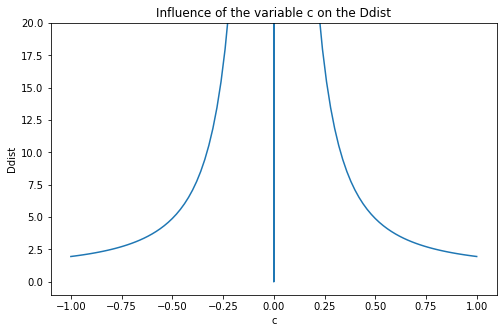

In [140]:
# %load question3
import matplotlib.pyplot as plt
import numpy as np

X1, X2, Y = sample(sigma=10, n=10000)

Ddist = []
C =  np.linspace(-1, 1, 101)
w  = np.array([1,0])

for c in C:
    X=np.concatenate([X1,X2], axis=1)
    phi = np.array([[1, 0],
                   [0, c]])
    we = regressor(Y, X@phi)
    Ddist.append(((we-w)@(we-w).T).sum())
plt.figure(figsize=(8,5))
plt.ylim(-1, 20)
plt.plot(C, Ddist)
plt.ylabel('Ddist')
plt.xlabel('c')
plt.title('Influence of the variable c on the Ddist')
plt.show()

The previous curve exhibits a clear issue with $\mathbb{D}_{dist}$ : it is discontinous at $c=0$ which is the targeted value eliciting an invariant predictor. Even with a severe ridge regression instead of a linear regression, the same phenomenom could be observed, a little change in the previous cell allows to see it.
Thus, the distance developped by authors to override this problem is just undoing the matrix inversion in the previous formula and calculating the square norm of the difference : $$$$
$$\mathbb{D}_{lin}(w,\Phi,e) = \|\mathbb{E}_{X^e}[\Phi(X^e)\Phi(X^e)^{T}]\cdot w- \mathbb{E}_{X^e,Y^e}[\Phi(X^e)Y^e]\|^2$$ $$$$
This distance can be interpreted as a measure of how much does the classifier $w$ violate the normal equations.

#### Question 4

Once again, plot $\mathbb{D}_{lin}(w,\Phi,e)$ as a function of c with the same parameters than **Question 3**.

Spoiler : You should obtain a much more smooth curve this time !!

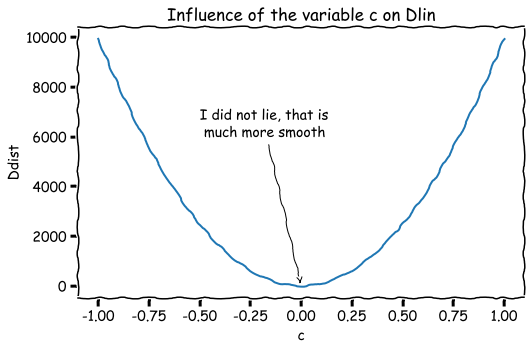

In [362]:
# %load question4
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

X1, X2, Y = sample(sigma=10, n=10000)

Dlin = []
C =  np.linspace(-1, 1, 101)
w  = np.array([1,0])

for c in C:
    X=np.concatenate([X1,X2], axis=1)
    phi = np.array([[1, 0],
                   [0, c]])
    u = (phi.T @ X.T @ X @ phi @ w - Y.T @ X @ phi)/Y.shape[0]
    Dlin.append((u @ u.T).sum())
    #Dlin.append((np.linalg.norm(phi.T @ X.T @ X @ phi @ w - phi.T @ X.T @ Y) / X.shape[0])**2)

with plt.xkcd(0.8, 40, 5): #don't hesitate to comment this line if you don't enjoy the graph
    fig, ax = plt.subplots(figsize=(8,5))
    ax.annotate(
        'I did not lie, that is\n much more smooth',
        xy=(0, 0), arrowprops=dict(arrowstyle='->'), xytext=(-0.5, 6000))
    ax.plot(C, Dlin)
    plt.ylabel('Ddist')
    plt.xlabel('c')
    plt.title('Influence of the variable c on Dlin')
    plt.show()

**3) Fixing $w$** 

Suppose now an invertible mapping $\Psi:\mathbb{H}\rightarrow\mathbb{H'}$, we can rewrite our invariant predictor $w\circ\Phi$ as :$$$$
$$w\circ\Phi = (w\circ\Psi^{-1})\circ(\Psi\circ\Phi) = \bar w\circ\bar \Phi$$
$$$$
This observation is in fact a real issue for our study case. Indeed, if you consider the invertible mapping $\Psi_{\gamma}(h) = \gamma\cdot h$, the distance $\mathbb{D}_{lin}(w,\Phi,e) = \mathbb{D}_{lin}(\dfrac1\gamma \cdot w,\gamma\cdot\Phi,e)$ tends to zero by letting $\gamma$ tend to zero, while the ERM term $R^e((\dfrac1\gamma \cdot w) \circ (\gamma\cdot\Phi))$ is not affected. This is due to the fact that we dealing with an over-parametrized problem.
To fix it, the solution is to choose a regressor $\bar w$ and to restrict our search on data representations for which the optimal classifier on each environnement is the same fixed classifier $\bar w$. $$$$

At this point our function to be minimized can be expressed as : $$$$
$$L_{IRM, w=\bar w}(\Phi) = \sum_{e\in\xi_{tr}}R^e(\bar w \circ \Phi) + \lambda\cdot\mathbb{D}_{lin}(\bar w,\Phi,e)$$

**4) Scalar classifier are sufficient to monitor invariance**

The previous point suggests we can arbitrarly choose $\bar w$, in the following we will choose $\bar w = \begin{pmatrix}1 & 0 & \cdots & 0\end{pmatrix}$. With such a choice, only the first component of the data representation would matter. As it could be surprising, the authors provides a demonstration in the case where the data representation is linear. You can find the explanation in part *3.1.4 Scalar fixed classifiers $\bar w$ are sufficient to monitor invariance* (*p 8*) and the demonstration of the theorem used in Appendix *B.2 Proof of Theorem 4* (*pp 27-28*)

Thus, this choice amounts to take $w=1$ scalar.

**5) Final formulation**

Remind that $R^e(f):=\mathbb{E}_{X^e,Y^e}[l(f(X^e),Y^e)]$, then for any convex norm $l$, we get :$$$$
$$\|\nabla_{w|w=1}R^e(w\cdot \Phi)\|^2 = \mathbb{D}_{lin}(w,\Phi,e)$$
$$$$
By using mini-batches for stochastic gradient descent, an unbiased estimator of this term could be obtained as $$$$
$$\sum\limits_{k=1}^{B}[\nabla_{w|w=1}l(w\cdot\Phi(X^{e,i}_k),Y^{e,i}_k)\cdot\nabla_{w|w=1}l(w\cdot\Phi(X^{e,j}_k),Y^{e,j}_k)]$$
$$$$
with $(X^{e,i}_k,Y^{e,i}_k),(X^{e,j}_k,Y^{e,j}_k)$ two random mini-batches of size $B$.

That's all, you now have all the knowledge required to perform your first invariant risk minimization !!

## Let's code and test this model !

### 1) Application on our toy example

From now we will use torch which provides a very powerful and practical tool to compute gradient ! 

In [141]:
#Generate n samples under environnement sigma
def sample_torch(n=10000, sigma=1.0):
    X1 = torch.normal(0.0, sigma, size=(n,1))
    y = X1 + torch.normal(0.0, sigma, size=(n,1))
    X2 = y + torch.normal(0.0, 1, size=(n,1))
    return X1, X2, y

#### Question 5

From the losses tensor under environnement e $$$$ $$losses=\begin{pmatrix} \cdots & l(w\cdot\Phi(X^{e}_k),Y^{e}_k)&\cdots \end{pmatrix}^T$$ $$$$create a function that computes $\mathbb{D}_{lin}(w,\Phi,e)$ thanks to its unbiased estimator.
You could use the function *grad* from *torch.autograd* with the attribute *create_graph=True* to compute the gradient.

In [142]:
# %load question5
import torch
from torch.autograd import grad

def D_lin(losses, w):
    #shuffle the losses
    permutation = torch.randperm(losses.shape[0])
    losses = losses[permutation]
    
    #create two mini-batches of size losses.shape[0]/2
    #list[a::n] returns a list containing elements indexed by a+k*n from the original list.
    batch_1 = losses[0::2]
    batch_2 = losses[1::2]
    D = 0
    for b1,b2 in tqdm(zip(batch_1, batch_2)):
        grad_1 = grad(b1, w, create_graph=True, retain_graph=True)[0]
        grad_2 = grad(b2, w, create_graph=True, retain_graph=True)[0] 
        D += grad_1 * grad_2
    return D

If you test the previous function with a losses of shape (5000,1), you will see that this function is really long (about 1min50 to run), it is due to the grad function which is really expensive to compute. As the algorithm requires using this function once a epoch, you could imagine how long it will take to train a relatively easy example.

Fortunately it is possible to strongly decrease this time of calculation checking that $$$$
$$\sum\limits_{k=1}^{B}[\nabla_{w|w=1}l(w\cdot\Phi(X^{e,i}_k),Y^{e,i}_k)\cdot\nabla_{w|w=1}l(w\cdot\Phi(X^{e,j}_k),Y^{e,j}_k)]$$ $$\simeq B\cdot\nabla_{w|w=1}\dfrac1B\sum\limits_{k=1}^{B}\Phi(X^{e,i}_k),Y^{e,i}_k)\cdot\nabla_{w|w=1}\dfrac1B\sum\limits_{k=1}^{B}\Phi(X^{e,j}_k),Y^{e,j}_k)$$

As the trade-off predictive power/invariance is regulated by $\lambda$, we will overlooked the $B$ coefficient in the previous formula. 

#### Question 6

Use the previous remark to compute an estimation of $\mathbb{D}_{lin}(w,\Phi,e)$

In [106]:
# %load question6
import torch
from torch.autograd import grad

def D_lin_efficient(losses, w):
    #shuffle the losses
    permutation = torch.randperm(losses.shape[0])
    losses = losses[permutation]
    
    #create two mini-batches of size losses.shape[0]/2
    #list[a::n] returns a list containing elements indexed by a+k*n from the original list.
    batch_1 = losses[0::2]
    batch_2 = losses[1::2]
    
    grad_1 = grad(batch_1.mean(), w, create_graph=True)[0] 
    grad_2 = grad(batch_2.mean(), w, create_graph=True)[0] 
    
    #As the result grad_1 * grad_2 is a tensor of shape [1], 
    #we use .sum() to "transform" it into scalar 
    return (grad_1 * grad_2).sum() 

We can now put all these elements together and see how well our Invariant Risk Minimization algorithm performs on our original example !!

In [132]:
#Define several environnements
n = 10000
environments = [sample_torch(n=n, sigma=1), sample_torch(n=n, sigma=0.1)]

In [135]:
# Define parameters, loss and optimizer of the model
phi = torch.nn.Parameter(torch.ones((2,1)))
w = torch.nn.Parameter(torch.Tensor([1.0]))

mse = torch.nn.MSELoss(reduction="none")

optimizer = torch.optim.SGD([phi], lr=1e-3) 

In [136]:
#Instantiate our penalization coefficient
lambda_ = 1e-5

In [138]:
from tqdm import tqdm

for iteration in tqdm(range(50000)):
    R = 0
    D = 0
    for X1,X2, Y in environments:
        X = torch.cat((X1,X2),1)
        losses = mse(X @ phi * w, Y)
        D += D_lin_efficient(losses, w)
        R += losses.mean()
    
    loss = lambda_ * R + D
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iteration % 5000 == 0: print(phi)

  0%|                                       | 72/50000 [00:00<02:20, 354.85it/s]

Parameter containing:
tensor([[0.9696],
        [0.1162]], requires_grad=True)


 10%|███▊                                 | 5079/50000 [00:16<01:46, 421.07it/s]

Parameter containing:
tensor([[0.9920],
        [0.0679]], requires_grad=True)


 20%|███████▎                            | 10072/50000 [00:31<01:48, 369.42it/s]

Parameter containing:
tensor([[0.9972],
        [0.0516]], requires_grad=True)


 30%|██████████▊                         | 15031/50000 [00:43<01:48, 322.14it/s]

Parameter containing:
tensor([[0.9994],
        [0.0426]], requires_grad=True)


 40%|██████████████▍                     | 20063/50000 [00:58<01:06, 450.81it/s]

Parameter containing:
tensor([[1.0007],
        [0.0368]], requires_grad=True)


 50%|██████████████████                  | 25045/50000 [01:09<01:02, 400.78it/s]

Parameter containing:
tensor([[1.0014],
        [0.0329]], requires_grad=True)


 60%|█████████████████████▋              | 30088/50000 [01:20<00:43, 460.29it/s]

Parameter containing:
tensor([[1.0020],
        [0.0296]], requires_grad=True)


 70%|█████████████████████████▎          | 35080/50000 [01:31<00:32, 458.86it/s]

Parameter containing:
tensor([[1.0024],
        [0.0272]], requires_grad=True)


 80%|████████████████████████████▊       | 40053/50000 [01:42<00:21, 460.01it/s]

Parameter containing:
tensor([[1.0027],
        [0.0251]], requires_grad=True)


 90%|████████████████████████████████▍   | 45051/50000 [01:53<00:11, 434.59it/s]

Parameter containing:
tensor([[1.0029],
        [0.0235]], requires_grad=True)


100%|████████████████████████████████████| 50000/50000 [02:04<00:00, 400.53it/s]


As expected our algorithm found the value of $\Phi$ which elicits an invariant regressor. Furthermore, it as converged to it quite quickly (about 10000 steps).

### 2) A more complex problem 

In [572]:
#!pip install torchvision
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd


# Load MNIST, make train/val splits, and shuffle train set examples

mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_image, mnist_label = mnist.data[:10000], mnist.targets[:10000]

In [558]:
mnist_even = mnist_image[mnist_label%2==0]
mnist_odd = mnist_image[mnist_label%2==1]

In [559]:
def environment(odd, even, env):
    odd = odd[:,::2,::2]
    even = even[:,::2,::2]
    odd = torch.stack((env/255*odd,(1-env)/255*odd), 3)
    even = torch.stack(((1-env)/255*even,env/255*even), 3)
    even_label = torch.ones(even.shape[0])
    odd_label = torch.zeros(odd.shape[0])
    labels = torch.concat((even_label, odd_label), 0)
    images = torch.concat((even, odd), 0)
    perm = torch.randperm(len(labels))
    
    return {
      'images': images[perm],
      'labels': labels[perm]
    }

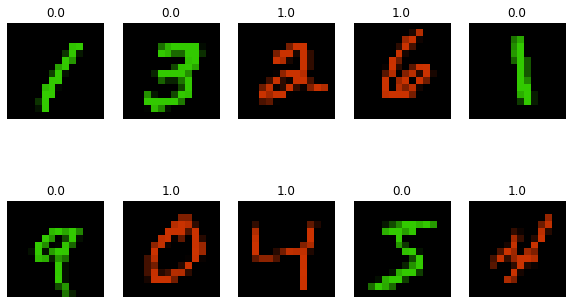

In [561]:
test = environment(mnist_odd[:5], mnist_even[:5], 0.2)

images = test["images"]
labels = test["labels"]

fig, axs = plt.subplots(2,5, figsize=(10,6))
for k in range(10):
    #such a great way to plot, using the euclidean division
    axs[k%2,k%5].imshow(torch.concat((images[k], torch.zeros((14,14,1))), 2))
    axs[k%2,k%5].set_axis_off()
    axs[k%2,k%5].set_title(labels[k].item())

In [562]:
model_irm = nn.Sequential(nn.Linear(14*14*2,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,1, bias=False),
                     nn.Sigmoid())

model_erm = nn.Sequential(nn.Linear(14*14*2,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,1, bias=False),
                     nn.Sigmoid())

In [563]:
bce = nn.BCELoss(reduction="none")

In [564]:
environments = [environment(mnist_odd[:1000], mnist_even[:1000], 0.1), environment(mnist_odd[1000:2000], mnist_even[1000:2000], 0.5)]

In [565]:
def D_(losses, w):
    grad = autograd.grad(losses.mean(), w, create_graph=True)[0]
    return torch.sum(grad**2)

w = torch.nn.Parameter(torch.Tensor([1.0]))
lambda_ = 1e-3
optimizer_erm = optim.Adam(model_erm.parameters(), lr=1e-3)
optimizer_irm = optim.Adam(model_irm.parameters(), lr=1e-3)

for iteration in tqdm(range(5000)):
    R_irm = 0
    D_irm = 0
    
    loss_erm = 0
    
    for data in environments:
        images = data['images']
        images = images.view(images.shape[0],-1)
        labels = data['labels']
        
        losses = bce(model_irm(images).ravel() * w, labels)
        D_irm += D_(losses, w)#_lin_efficient(losses, w)
        R_irm += losses.mean()
        
        loss_erm += bce(model_erm(images).ravel() * w, labels).mean()
        
    
    loss_irm = lambda_ * R_irm + D_irm
    
    optimizer_irm.zero_grad()
    loss_irm.backward()
    optimizer_irm.step()
    
    optimizer_erm.zero_grad()
    loss_erm.backward()
    optimizer_erm.step()

100%|███████████████████████████████████████| 5000/5000 [18:48<00:00,  4.43it/s]


In [566]:
envtest = environment(mnist_odd[2500:3000], mnist_even[3000:3500], 0.7)
im = envtest["images"]
lab = envtest["labels"]

In [567]:
pred_irm = (model_irm(im.view(im.shape[0],-1))>0.5).float().ravel()
pred_erm = (model_erm(im.view(im.shape[0],-1))>0.5).float().ravel()

In [568]:
accuracy_irm = (pred_irm==lab).float().mean()
accuracy_erm = (pred_erm==lab).float().mean()

In [571]:
print('On a different environment, the Ivariant Risk Minimization paradigm achieves an accuracy of %f percent while the\nExperiment Risk Minimization achieves %f percent.' %(accuracy_irm*100, accuracy_erm*100))

On a different environment, the Ivariant Risk Minimization paradigm achieves an accuracy of 56.900002 percent while the
Experiment Risk Minimization achieves 32.400002 percent.


# A bouger si ca marche au dessus

In [556]:
#!pip install torchvision

In [145]:
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd


# Load MNIST, make train/val splits, and shuffle train set examples

mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:50000], mnist.targets[:50000])
mnist_val = (mnist.data[50000:], mnist.targets[50000:])

rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /Users/clementnicolle/datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /Users/clementnicolle/datasets/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /Users/clementnicolle/datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/clementnicolle/datasets/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /Users/clementnicolle/datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/clementnicolle/datasets/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /Users/clementnicolle/datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/clementnicolle/datasets/mnist/MNIST/raw



In [173]:
mnist_image, mnist_label = mnist.data[:10000], mnist.targets[:10000]

In [180]:
mnist_label%2==0

tensor([False, False, False,  ..., False, False, False])

In [234]:
mnist_even = mnist_image[mnist_label%2==0]
mnist_odd = mnist_image[mnist_label%2==1]

In [248]:
def environment(odd, even, env):
    odd = odd[:,::2,::2]
    even = even[:,::2,::2]
    odd = torch.stack((env/255*odd,(1-env)/255*odd), 3)
    even = torch.stack(((1-env)/255*even,env/255*even), 3)
    even_label = torch.ones(even.shape[0])
    odd_label = torch.zeros(odd.shape[0])
    labels = torch.concat((even_label, odd_label), 0)
    images = torch.concat((even, odd), 0)
    perm = torch.randperm(len(labels))
    
    return {
      'images': images[perm],
      'labels': labels[perm]
    }

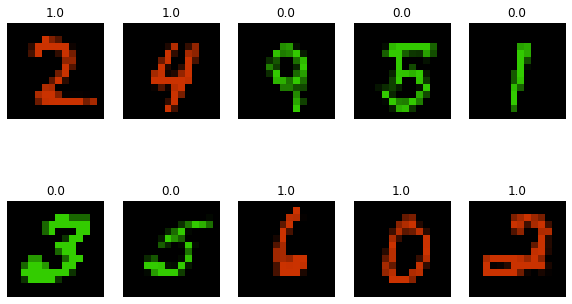

In [300]:
test = environment(mnist_odd[:5], mnist_even[:5], 0.2)

images = test["images"]
labels = test["labels"]

fig, axs = plt.subplots(2,5, figsize=(10,6))
for k in range(10):
    #such a great way to plot, using the euclidean division
    axs[k%2,k%5].imshow(torch.concat((images[k], torch.zeros((14,14,1))), 2))
    axs[k%2,k%5].set_axis_off()
    axs[k%2,k%5].set_title(labels[k].item())

In [517]:
model = nn.Sequential(nn.Linear(14*14*2,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,1, bias=False),
                     nn.Sigmoid())

In [518]:
A = images.view(images.shape[0],-1)
A.shape

torch.Size([2000, 392])

In [519]:
model(A).ravel().shape

torch.Size([2000])

In [520]:
bce = nn.BCELoss(reduction="none")
#bce(model(A).ravel(),labels)

In [521]:
environments = [environment(mnist_odd[:1000], mnist_even[:1000], 0.1), environment(mnist_odd[1000:2000], mnist_even[1000:2000], 0.5)]

In [522]:
def D_(losses, w):
    grad = autograd.grad(losses.mean(), w, create_graph=True)[0]
    return torch.sum(grad**2)

In [523]:
w = torch.nn.Parameter(torch.Tensor([1.0]))
lambda_ = 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for iteration in tqdm(range(10000)):
    R = 0
    D = 0
    for data in environments:
        images = data['images']
        images = images.view(images.shape[0],-1)
        labels = data['labels']
        
        losses = bce(model(images).ravel() * w, labels)
        D += D_(losses, w)#_lin_efficient(losses, w)
        R += losses.mean()
    if (iteration%100==0):    
        print(D)
        print(R)
    
    loss = lambda_ * R + D
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|                                         | 1/10000 [00:00<18:09,  9.18it/s]

tensor(2.9167e-06, grad_fn=<AddBackward0>)
tensor(1.3890, grad_fn=<AddBackward0>)


  1%|▍                                      | 103/10000 [00:05<08:52, 18.59it/s]

tensor(6.4228e-06, grad_fn=<AddBackward0>)
tensor(1.2153, grad_fn=<AddBackward0>)


  2%|▊                                      | 203/10000 [00:11<09:00, 18.12it/s]

tensor(4.8083e-07, grad_fn=<AddBackward0>)
tensor(0.8503, grad_fn=<AddBackward0>)


  3%|█▏                                     | 303/10000 [00:16<08:46, 18.42it/s]

tensor(6.3330e-08, grad_fn=<AddBackward0>)
tensor(0.8230, grad_fn=<AddBackward0>)


  4%|█▌                                     | 403/10000 [00:22<08:36, 18.57it/s]

tensor(5.6718e-07, grad_fn=<AddBackward0>)
tensor(0.8083, grad_fn=<AddBackward0>)


  5%|█▉                                     | 503/10000 [00:27<09:01, 17.53it/s]

tensor(1.4239e-05, grad_fn=<AddBackward0>)
tensor(0.7990, grad_fn=<AddBackward0>)


  6%|██▎                                    | 603/10000 [00:33<10:00, 15.66it/s]

tensor(2.1891e-05, grad_fn=<AddBackward0>)
tensor(0.7653, grad_fn=<AddBackward0>)


  7%|██▋                                    | 703/10000 [00:39<08:41, 17.82it/s]

tensor(8.0013e-06, grad_fn=<AddBackward0>)
tensor(0.7460, grad_fn=<AddBackward0>)


  8%|███▏                                   | 803/10000 [00:45<08:35, 17.85it/s]

tensor(6.1838e-05, grad_fn=<AddBackward0>)
tensor(0.7775, grad_fn=<AddBackward0>)


  9%|███▌                                   | 903/10000 [00:50<08:21, 18.14it/s]

tensor(4.0483e-08, grad_fn=<AddBackward0>)
tensor(0.7384, grad_fn=<AddBackward0>)


 10%|███▊                                  | 1003/10000 [00:56<08:17, 18.08it/s]

tensor(3.0218e-06, grad_fn=<AddBackward0>)
tensor(0.7002, grad_fn=<AddBackward0>)


 11%|████▏                                 | 1103/10000 [01:01<08:21, 17.73it/s]

tensor(4.9717e-06, grad_fn=<AddBackward0>)
tensor(0.6787, grad_fn=<AddBackward0>)


 12%|████▌                                 | 1203/10000 [01:07<08:06, 18.07it/s]

tensor(4.8743e-06, grad_fn=<AddBackward0>)
tensor(0.6515, grad_fn=<AddBackward0>)


 13%|████▉                                 | 1303/10000 [01:13<07:57, 18.23it/s]

tensor(2.3070e-07, grad_fn=<AddBackward0>)
tensor(0.6380, grad_fn=<AddBackward0>)


 14%|█████▎                                | 1403/10000 [01:19<07:58, 17.97it/s]

tensor(1.5202e-06, grad_fn=<AddBackward0>)
tensor(0.6193, grad_fn=<AddBackward0>)


 15%|█████▋                                | 1503/10000 [01:25<07:50, 18.05it/s]

tensor(1.1797e-06, grad_fn=<AddBackward0>)
tensor(0.6107, grad_fn=<AddBackward0>)


 16%|██████                                | 1603/10000 [01:30<07:44, 18.07it/s]

tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.5407, grad_fn=<AddBackward0>)


 17%|██████▍                               | 1703/10000 [01:36<07:38, 18.11it/s]

tensor(2.6917e-06, grad_fn=<AddBackward0>)
tensor(0.5731, grad_fn=<AddBackward0>)


 18%|██████▊                               | 1803/10000 [01:41<07:31, 18.14it/s]

tensor(4.2746e-06, grad_fn=<AddBackward0>)
tensor(0.5088, grad_fn=<AddBackward0>)


 19%|███████▏                              | 1903/10000 [01:47<07:24, 18.20it/s]

tensor(1.3510e-05, grad_fn=<AddBackward0>)
tensor(0.5215, grad_fn=<AddBackward0>)


 20%|███████▌                              | 2001/10000 [01:55<13:06, 10.17it/s]

tensor(1.0357e-05, grad_fn=<AddBackward0>)
tensor(0.4342, grad_fn=<AddBackward0>)


 21%|███████▉                              | 2103/10000 [02:03<07:46, 16.95it/s]

tensor(1.8111e-06, grad_fn=<AddBackward0>)
tensor(0.5681, grad_fn=<AddBackward0>)


 22%|████████▎                             | 2203/10000 [02:10<07:05, 18.31it/s]

tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.4848, grad_fn=<AddBackward0>)


 23%|████████▋                             | 2301/10000 [02:15<07:17, 17.59it/s]

tensor(5.7152e-07, grad_fn=<AddBackward0>)
tensor(0.4089, grad_fn=<AddBackward0>)


 24%|█████████▏                            | 2404/10000 [02:24<07:37, 16.61it/s]

tensor(2.7718e-07, grad_fn=<AddBackward0>)
tensor(0.3573, grad_fn=<AddBackward0>)


 25%|█████████▌                            | 2504/10000 [02:30<06:56, 18.00it/s]

tensor(0.0014, grad_fn=<AddBackward0>)
tensor(0.3186, grad_fn=<AddBackward0>)


 26%|█████████▉                            | 2603/10000 [02:35<06:12, 19.83it/s]

tensor(7.8262e-05, grad_fn=<AddBackward0>)
tensor(0.2833, grad_fn=<AddBackward0>)


 27%|██████████▎                           | 2703/10000 [02:40<06:07, 19.84it/s]

tensor(4.3308e-06, grad_fn=<AddBackward0>)
tensor(0.2670, grad_fn=<AddBackward0>)


 28%|██████████▋                           | 2803/10000 [02:45<06:03, 19.79it/s]

tensor(2.8645e-05, grad_fn=<AddBackward0>)
tensor(0.2296, grad_fn=<AddBackward0>)


 29%|███████████                           | 2904/10000 [02:50<05:55, 19.95it/s]

tensor(1.0350e-05, grad_fn=<AddBackward0>)
tensor(0.1922, grad_fn=<AddBackward0>)


 30%|███████████▍                          | 3004/10000 [02:55<05:53, 19.77it/s]

tensor(2.9580e-06, grad_fn=<AddBackward0>)
tensor(0.1682, grad_fn=<AddBackward0>)


 31%|███████████▊                          | 3104/10000 [03:02<05:55, 19.38it/s]

tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.1547, grad_fn=<AddBackward0>)


 32%|████████████▏                         | 3204/10000 [03:08<05:51, 19.33it/s]

tensor(2.8849e-05, grad_fn=<AddBackward0>)
tensor(0.1379, grad_fn=<AddBackward0>)


 33%|████████████▌                         | 3304/10000 [03:13<05:41, 19.62it/s]

tensor(1.8897e-05, grad_fn=<AddBackward0>)
tensor(0.1234, grad_fn=<AddBackward0>)


 34%|████████████▉                         | 3404/10000 [03:18<05:34, 19.73it/s]

tensor(2.2030e-05, grad_fn=<AddBackward0>)
tensor(0.1092, grad_fn=<AddBackward0>)


 35%|█████████████▎                        | 3504/10000 [03:23<05:29, 19.71it/s]

tensor(1.0518e-05, grad_fn=<AddBackward0>)
tensor(0.1071, grad_fn=<AddBackward0>)


 36%|█████████████▋                        | 3604/10000 [03:28<05:28, 19.48it/s]

tensor(1.4259e-07, grad_fn=<AddBackward0>)
tensor(0.0911, grad_fn=<AddBackward0>)


 37%|██████████████                        | 3704/10000 [03:34<05:22, 19.52it/s]

tensor(9.4541e-06, grad_fn=<AddBackward0>)
tensor(0.0832, grad_fn=<AddBackward0>)


 38%|██████████████▍                       | 3804/10000 [03:39<05:14, 19.68it/s]

tensor(1.3752e-07, grad_fn=<AddBackward0>)
tensor(0.0726, grad_fn=<AddBackward0>)


 39%|██████████████▊                       | 3904/10000 [03:44<05:15, 19.34it/s]

tensor(4.5267e-05, grad_fn=<AddBackward0>)
tensor(0.0673, grad_fn=<AddBackward0>)


 40%|███████████████▏                      | 4004/10000 [03:49<05:06, 19.59it/s]

tensor(2.3297e-06, grad_fn=<AddBackward0>)
tensor(0.0601, grad_fn=<AddBackward0>)


 41%|███████████████▌                      | 4104/10000 [03:54<05:02, 19.50it/s]

tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0542, grad_fn=<AddBackward0>)


 42%|███████████████▉                      | 4204/10000 [04:00<04:56, 19.52it/s]

tensor(2.0817e-06, grad_fn=<AddBackward0>)
tensor(0.0500, grad_fn=<AddBackward0>)


 43%|████████████████▎                     | 4304/10000 [04:05<04:59, 19.05it/s]

tensor(1.8073e-05, grad_fn=<AddBackward0>)
tensor(0.0455, grad_fn=<AddBackward0>)


 44%|████████████████▋                     | 4404/10000 [04:10<04:45, 19.61it/s]

tensor(2.4961e-05, grad_fn=<AddBackward0>)
tensor(0.0418, grad_fn=<AddBackward0>)


 45%|█████████████████                     | 4504/10000 [04:15<04:42, 19.49it/s]

tensor(3.9647e-05, grad_fn=<AddBackward0>)
tensor(0.0397, grad_fn=<AddBackward0>)


 46%|█████████████████▍                    | 4604/10000 [04:20<04:43, 19.06it/s]

tensor(9.4288e-05, grad_fn=<AddBackward0>)
tensor(0.0369, grad_fn=<AddBackward0>)


 47%|█████████████████▉                    | 4704/10000 [04:26<04:34, 19.28it/s]

tensor(4.9221e-06, grad_fn=<AddBackward0>)
tensor(0.0348, grad_fn=<AddBackward0>)


 48%|██████████████████▎                   | 4804/10000 [04:31<04:26, 19.53it/s]

tensor(1.6307e-06, grad_fn=<AddBackward0>)
tensor(0.0329, grad_fn=<AddBackward0>)


 49%|██████████████████▋                   | 4902/10000 [04:37<06:22, 13.32it/s]

tensor(6.1752e-06, grad_fn=<AddBackward0>)
tensor(0.0321, grad_fn=<AddBackward0>)


 50%|███████████████████                   | 5004/10000 [04:43<04:21, 19.08it/s]

tensor(3.4354e-05, grad_fn=<AddBackward0>)
tensor(0.0308, grad_fn=<AddBackward0>)


 51%|███████████████████▍                  | 5104/10000 [04:49<04:23, 18.57it/s]

tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0295, grad_fn=<AddBackward0>)


 52%|███████████████████▊                  | 5204/10000 [04:54<04:09, 19.26it/s]

tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0289, grad_fn=<AddBackward0>)


 53%|████████████████████▏                 | 5304/10000 [04:59<04:02, 19.40it/s]

tensor(4.9362e-05, grad_fn=<AddBackward0>)
tensor(0.0280, grad_fn=<AddBackward0>)


 54%|████████████████████▌                 | 5402/10000 [05:05<04:23, 17.46it/s]

tensor(1.0228e-06, grad_fn=<AddBackward0>)
tensor(0.0269, grad_fn=<AddBackward0>)


 55%|████████████████████▉                 | 5504/10000 [05:10<03:54, 19.18it/s]

tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0270, grad_fn=<AddBackward0>)


 56%|█████████████████████▎                | 5604/10000 [05:15<03:49, 19.16it/s]

tensor(9.2046e-06, grad_fn=<AddBackward0>)
tensor(0.0265, grad_fn=<AddBackward0>)


 57%|█████████████████████▋                | 5704/10000 [05:21<03:39, 19.59it/s]

tensor(4.7110e-05, grad_fn=<AddBackward0>)
tensor(0.0255, grad_fn=<AddBackward0>)


 58%|██████████████████████                | 5804/10000 [05:26<03:35, 19.45it/s]

tensor(5.5713e-06, grad_fn=<AddBackward0>)
tensor(0.0249, grad_fn=<AddBackward0>)


 59%|██████████████████████▍               | 5904/10000 [05:31<03:36, 18.93it/s]

tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0245, grad_fn=<AddBackward0>)


 60%|██████████████████████▊               | 6004/10000 [05:36<03:27, 19.29it/s]

tensor(1.9872e-06, grad_fn=<AddBackward0>)
tensor(0.0240, grad_fn=<AddBackward0>)


 61%|███████████████████████▏              | 6104/10000 [05:42<03:23, 19.10it/s]

tensor(1.7130e-06, grad_fn=<AddBackward0>)
tensor(0.0234, grad_fn=<AddBackward0>)


 62%|███████████████████████▌              | 6204/10000 [05:47<03:14, 19.54it/s]

tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0471, grad_fn=<AddBackward0>)


 63%|███████████████████████▉              | 6303/10000 [05:52<03:05, 19.89it/s]

tensor(4.2810e-06, grad_fn=<AddBackward0>)
tensor(0.0255, grad_fn=<AddBackward0>)


 64%|████████████████████████▎             | 6404/10000 [05:57<03:01, 19.81it/s]

tensor(3.1615e-07, grad_fn=<AddBackward0>)
tensor(0.0231, grad_fn=<AddBackward0>)


 65%|████████████████████████▋             | 6504/10000 [06:02<02:56, 19.80it/s]

tensor(6.2138e-07, grad_fn=<AddBackward0>)
tensor(0.0218, grad_fn=<AddBackward0>)


 66%|█████████████████████████             | 6604/10000 [06:08<02:52, 19.70it/s]

tensor(1.1860e-06, grad_fn=<AddBackward0>)
tensor(0.0207, grad_fn=<AddBackward0>)


 67%|█████████████████████████▍            | 6704/10000 [06:13<02:49, 19.50it/s]

tensor(4.3284e-07, grad_fn=<AddBackward0>)
tensor(0.0196, grad_fn=<AddBackward0>)


 68%|█████████████████████████▊            | 6804/10000 [06:18<02:44, 19.44it/s]

tensor(3.5185e-07, grad_fn=<AddBackward0>)
tensor(0.0187, grad_fn=<AddBackward0>)


 69%|██████████████████████████▏           | 6904/10000 [06:23<02:40, 19.23it/s]

tensor(2.0607e-07, grad_fn=<AddBackward0>)
tensor(0.0176, grad_fn=<AddBackward0>)


 70%|██████████████████████████▌           | 7004/10000 [06:29<02:39, 18.75it/s]

tensor(1.2094e-05, grad_fn=<AddBackward0>)
tensor(0.0166, grad_fn=<AddBackward0>)


 71%|██████████████████████████▉           | 7104/10000 [06:34<02:37, 18.41it/s]

tensor(4.1008e-07, grad_fn=<AddBackward0>)
tensor(0.0160, grad_fn=<AddBackward0>)


 72%|███████████████████████████▎          | 7202/10000 [06:40<02:39, 17.56it/s]

tensor(7.9009e-07, grad_fn=<AddBackward0>)
tensor(0.0156, grad_fn=<AddBackward0>)


 73%|███████████████████████████▋          | 7302/10000 [06:45<02:31, 17.76it/s]

tensor(3.6740e-07, grad_fn=<AddBackward0>)
tensor(0.0152, grad_fn=<AddBackward0>)


 74%|████████████████████████████▏         | 7402/10000 [06:51<02:26, 17.70it/s]

tensor(1.2821e-07, grad_fn=<AddBackward0>)
tensor(0.0148, grad_fn=<AddBackward0>)


 75%|████████████████████████████▌         | 7502/10000 [06:57<02:26, 17.07it/s]

tensor(2.5862e-06, grad_fn=<AddBackward0>)
tensor(0.0143, grad_fn=<AddBackward0>)


 76%|████████████████████████████▉         | 7602/10000 [07:03<02:23, 16.76it/s]

tensor(1.2836e-05, grad_fn=<AddBackward0>)
tensor(0.0138, grad_fn=<AddBackward0>)


 77%|█████████████████████████████▎        | 7702/10000 [07:09<02:21, 16.26it/s]

tensor(2.0386e-06, grad_fn=<AddBackward0>)
tensor(0.0134, grad_fn=<AddBackward0>)


 78%|█████████████████████████████▋        | 7802/10000 [07:16<02:23, 15.30it/s]

tensor(8.7661e-07, grad_fn=<AddBackward0>)
tensor(0.0128, grad_fn=<AddBackward0>)


 79%|██████████████████████████████        | 7902/10000 [07:22<02:15, 15.46it/s]

tensor(7.2009e-07, grad_fn=<AddBackward0>)
tensor(0.0123, grad_fn=<AddBackward0>)


 80%|██████████████████████████████▍       | 8002/10000 [07:29<02:17, 14.56it/s]

tensor(9.6809e-07, grad_fn=<AddBackward0>)
tensor(0.0119, grad_fn=<AddBackward0>)


 81%|██████████████████████████████▊       | 8102/10000 [07:36<02:12, 14.28it/s]

tensor(3.9018e-07, grad_fn=<AddBackward0>)
tensor(0.0115, grad_fn=<AddBackward0>)


 82%|███████████████████████████████▏      | 8202/10000 [07:43<02:10, 13.80it/s]

tensor(5.1998e-07, grad_fn=<AddBackward0>)
tensor(0.0112, grad_fn=<AddBackward0>)


 83%|███████████████████████████████▌      | 8302/10000 [07:53<02:21, 11.96it/s]

tensor(1.5230e-06, grad_fn=<AddBackward0>)
tensor(0.0110, grad_fn=<AddBackward0>)


 84%|███████████████████████████████▉      | 8401/10000 [08:01<02:05, 12.78it/s]

tensor(2.7092e-06, grad_fn=<AddBackward0>)
tensor(0.0109, grad_fn=<AddBackward0>)


 85%|████████████████████████████████▎     | 8501/10000 [08:09<01:59, 12.58it/s]

tensor(2.2599e-06, grad_fn=<AddBackward0>)
tensor(0.0109, grad_fn=<AddBackward0>)


 86%|████████████████████████████████▋     | 8601/10000 [08:17<01:56, 12.02it/s]

tensor(1.3921e-07, grad_fn=<AddBackward0>)
tensor(0.0107, grad_fn=<AddBackward0>)


 87%|█████████████████████████████████     | 8701/10000 [08:28<02:37,  8.24it/s]

tensor(9.8353e-07, grad_fn=<AddBackward0>)
tensor(0.0105, grad_fn=<AddBackward0>)


 88%|█████████████████████████████████▍    | 8802/10000 [08:38<01:56, 10.31it/s]

tensor(7.4645e-07, grad_fn=<AddBackward0>)
tensor(0.0103, grad_fn=<AddBackward0>)


 89%|█████████████████████████████████▊    | 8901/10000 [08:48<02:14,  8.14it/s]

tensor(6.1191e-07, grad_fn=<AddBackward0>)
tensor(0.0100, grad_fn=<AddBackward0>)


 90%|██████████████████████████████████▏   | 9002/10000 [08:58<01:36, 10.32it/s]

tensor(8.3318e-06, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)


 91%|██████████████████████████████████▌   | 9101/10000 [09:08<01:32,  9.69it/s]

tensor(5.2032e-06, grad_fn=<AddBackward0>)
tensor(0.0092, grad_fn=<AddBackward0>)


 92%|██████████████████████████████████▉   | 9202/10000 [09:19<01:28,  8.99it/s]

tensor(4.8630e-06, grad_fn=<AddBackward0>)
tensor(0.0090, grad_fn=<AddBackward0>)


 93%|███████████████████████████████████▎  | 9301/10000 [09:30<01:23,  8.37it/s]

tensor(8.9164e-08, grad_fn=<AddBackward0>)
tensor(0.0088, grad_fn=<AddBackward0>)


 94%|███████████████████████████████████▋  | 9402/10000 [09:42<01:06,  9.01it/s]

tensor(1.6671e-06, grad_fn=<AddBackward0>)
tensor(0.0084, grad_fn=<AddBackward0>)


 95%|████████████████████████████████████  | 9501/10000 [09:53<00:55,  8.98it/s]

tensor(2.4731e-07, grad_fn=<AddBackward0>)
tensor(0.0082, grad_fn=<AddBackward0>)


 96%|████████████████████████████████████▍ | 9601/10000 [10:04<00:46,  8.55it/s]

tensor(2.5081e-07, grad_fn=<AddBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)


 97%|████████████████████████████████████▊ | 9701/10000 [10:16<00:35,  8.53it/s]

tensor(3.2891e-07, grad_fn=<AddBackward0>)
tensor(0.0077, grad_fn=<AddBackward0>)


 98%|█████████████████████████████████████▏| 9801/10000 [10:28<00:24,  8.17it/s]

tensor(3.5791e-07, grad_fn=<AddBackward0>)
tensor(0.0076, grad_fn=<AddBackward0>)


 99%|█████████████████████████████████████▌| 9901/10000 [10:40<00:11,  8.46it/s]

tensor(3.8235e-07, grad_fn=<AddBackward0>)
tensor(0.0076, grad_fn=<AddBackward0>)


100%|█████████████████████████████████████| 10000/10000 [10:53<00:00, 15.31it/s]


In [524]:
(model(images)[:10]>0.5).float()

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]])

In [525]:
labels[:10]

tensor([1., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [544]:
envtest = environment(mnist_odd[2500:3000], mnist_even[3000:3500], 0.7)
im = envtest["images"]
lab = envtest["labels"]

In [545]:
pred = (model(im.view(im.shape[0],-1))>0.5).float().ravel()

In [547]:
(pred==lab).float().mean()

tensor(0.5930)

In [552]:
model_erm = nn.Sequential(nn.Linear(14*14*2,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,400, bias=False),
                     nn.ReLU(),
                     nn.Linear(400,1, bias=False),
                     nn.Sigmoid())

In [553]:
lambda_ = 1e-3
optimizer = optim.Adam(model_erm.parameters(), lr=1e-3)

for iteration in tqdm(range(5000)):
    R = 0
    for data in environments:
        images = data['images']
        images = images.view(images.shape[0],-1)
        labels = data['labels']
        
        losses = bce(model_erm(images).ravel() * w, labels)
        R += losses.mean()
    if (iteration%100==0): 
        print(R)
    
    loss = R
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|                                          | 2/5000 [00:00<09:03,  9.20it/s]

tensor(1.3844, grad_fn=<AddBackward0>)


  2%|▊                                       | 102/5000 [00:06<05:09, 15.82it/s]

tensor(0.0106, grad_fn=<AddBackward0>)


  4%|█▌                                      | 202/5000 [00:12<05:14, 15.26it/s]

tensor(0.0010, grad_fn=<AddBackward0>)


  6%|██▍                                     | 302/5000 [00:19<06:37, 11.83it/s]

tensor(0.0004, grad_fn=<AddBackward0>)


  8%|███▏                                    | 402/5000 [00:28<07:03, 10.86it/s]

tensor(0.0002, grad_fn=<AddBackward0>)


 10%|████                                    | 502/5000 [00:38<07:57,  9.42it/s]

tensor(0.0001, grad_fn=<AddBackward0>)


 12%|████▊                                   | 602/5000 [00:50<08:00,  9.16it/s]

tensor(8.8883e-05, grad_fn=<AddBackward0>)


 14%|█████▌                                  | 701/5000 [01:01<07:56,  9.02it/s]

tensor(6.4859e-05, grad_fn=<AddBackward0>)


 16%|██████▍                                 | 802/5000 [01:12<07:39,  9.14it/s]

tensor(4.9389e-05, grad_fn=<AddBackward0>)


 18%|███████▏                                | 902/5000 [01:24<07:40,  8.91it/s]

tensor(3.8827e-05, grad_fn=<AddBackward0>)


 20%|███████▊                               | 1001/5000 [01:35<07:47,  8.55it/s]

tensor(3.1280e-05, grad_fn=<AddBackward0>)


 22%|████████▌                              | 1101/5000 [01:49<11:10,  5.81it/s]

tensor(2.5683e-05, grad_fn=<AddBackward0>)


 24%|█████████▎                             | 1201/5000 [02:02<07:54,  8.00it/s]

tensor(2.1431e-05, grad_fn=<AddBackward0>)


 26%|██████████▏                            | 1301/5000 [02:15<07:47,  7.91it/s]

tensor(1.8117e-05, grad_fn=<AddBackward0>)


 28%|██████████▉                            | 1401/5000 [02:28<07:41,  7.80it/s]

tensor(1.5489e-05, grad_fn=<AddBackward0>)


 30%|███████████▋                           | 1501/5000 [02:42<08:42,  6.70it/s]

tensor(1.3372e-05, grad_fn=<AddBackward0>)


 32%|████████████▍                          | 1601/5000 [02:57<08:11,  6.91it/s]

tensor(1.1640e-05, grad_fn=<AddBackward0>)


 34%|█████████████▎                         | 1701/5000 [03:14<07:05,  7.75it/s]

tensor(1.0206e-05, grad_fn=<AddBackward0>)


 36%|██████████████                         | 1801/5000 [03:27<06:58,  7.65it/s]

tensor(9.0031e-06, grad_fn=<AddBackward0>)


 38%|██████████████▊                        | 1901/5000 [03:41<06:53,  7.49it/s]

tensor(7.9872e-06, grad_fn=<AddBackward0>)


 40%|███████████████▌                       | 2001/5000 [03:55<07:01,  7.12it/s]

tensor(7.1213e-06, grad_fn=<AddBackward0>)


 42%|████████████████▍                      | 2101/5000 [04:09<06:40,  7.23it/s]

tensor(6.3780e-06, grad_fn=<AddBackward0>)


 44%|█████████████████▏                     | 2201/5000 [04:23<06:36,  7.07it/s]

tensor(5.7345e-06, grad_fn=<AddBackward0>)


 46%|█████████████████▉                     | 2301/5000 [04:37<06:27,  6.96it/s]

tensor(5.1751e-06, grad_fn=<AddBackward0>)


 48%|██████████████████▋                    | 2401/5000 [04:51<06:12,  6.97it/s]

tensor(4.6859e-06, grad_fn=<AddBackward0>)


 50%|███████████████████▌                   | 2501/5000 [05:07<07:16,  5.73it/s]

tensor(4.2537e-06, grad_fn=<AddBackward0>)


 52%|████████████████████▎                  | 2601/5000 [05:20<05:28,  7.30it/s]

tensor(3.8734e-06, grad_fn=<AddBackward0>)


 54%|█████████████████████                  | 2701/5000 [05:36<05:24,  7.09it/s]

tensor(3.5357e-06, grad_fn=<AddBackward0>)


 56%|█████████████████████▊                 | 2801/5000 [05:51<05:06,  7.17it/s]

tensor(3.2338e-06, grad_fn=<AddBackward0>)


 58%|██████████████████████▋                | 2901/5000 [06:05<04:55,  7.11it/s]

tensor(2.9644e-06, grad_fn=<AddBackward0>)


 60%|███████████████████████▍               | 3001/5000 [06:19<04:47,  6.94it/s]

tensor(2.7224e-06, grad_fn=<AddBackward0>)


 62%|████████████████████████▏              | 3101/5000 [06:33<04:28,  7.06it/s]

tensor(2.5057e-06, grad_fn=<AddBackward0>)


 64%|████████████████████████▉              | 3201/5000 [06:47<04:16,  7.01it/s]

tensor(2.3095e-06, grad_fn=<AddBackward0>)


 66%|█████████████████████████▋             | 3301/5000 [07:02<03:59,  7.08it/s]

tensor(2.1315e-06, grad_fn=<AddBackward0>)


 68%|██████████████████████████▌            | 3401/5000 [07:16<03:46,  7.07it/s]

tensor(1.9700e-06, grad_fn=<AddBackward0>)


 70%|███████████████████████████▎           | 3501/5000 [07:30<03:31,  7.08it/s]

tensor(1.8232e-06, grad_fn=<AddBackward0>)


 72%|████████████████████████████           | 3601/5000 [07:45<03:18,  7.03it/s]

tensor(1.6889e-06, grad_fn=<AddBackward0>)


 74%|████████████████████████████▊          | 3701/5000 [07:59<03:06,  6.98it/s]

tensor(1.5669e-06, grad_fn=<AddBackward0>)


 76%|█████████████████████████████▋         | 3801/5000 [08:14<03:05,  6.46it/s]

tensor(1.4549e-06, grad_fn=<AddBackward0>)


 78%|██████████████████████████████▍        | 3901/5000 [08:28<02:37,  6.96it/s]

tensor(1.3521e-06, grad_fn=<AddBackward0>)


 80%|███████████████████████████████▏       | 4001/5000 [08:43<02:28,  6.70it/s]

tensor(1.2578e-06, grad_fn=<AddBackward0>)


 82%|███████████████████████████████▉       | 4101/5000 [08:58<02:10,  6.87it/s]

tensor(1.1718e-06, grad_fn=<AddBackward0>)


 84%|████████████████████████████████▊      | 4201/5000 [09:13<01:58,  6.74it/s]

tensor(1.0914e-06, grad_fn=<AddBackward0>)


 86%|█████████████████████████████████▌     | 4301/5000 [09:28<01:42,  6.83it/s]

tensor(1.0196e-06, grad_fn=<AddBackward0>)


 88%|██████████████████████████████████▎    | 4401/5000 [09:43<01:27,  6.85it/s]

tensor(9.5120e-07, grad_fn=<AddBackward0>)


 90%|███████████████████████████████████    | 4501/5000 [09:57<01:13,  6.82it/s]

tensor(8.8838e-07, grad_fn=<AddBackward0>)


 92%|███████████████████████████████████▉   | 4601/5000 [10:12<00:59,  6.76it/s]

tensor(8.2982e-07, grad_fn=<AddBackward0>)


 94%|████████████████████████████████████▋  | 4701/5000 [10:27<00:44,  6.73it/s]

tensor(7.7623e-07, grad_fn=<AddBackward0>)


 96%|█████████████████████████████████████▍ | 4801/5000 [10:43<00:30,  6.59it/s]

tensor(7.2637e-07, grad_fn=<AddBackward0>)


 98%|██████████████████████████████████████▏| 4901/5000 [10:58<00:15,  6.60it/s]

tensor(6.8006e-07, grad_fn=<AddBackward0>)


100%|███████████████████████████████████████| 5000/5000 [11:13<00:00,  7.42it/s]


In [554]:
pred = (model_erm(im.view(im.shape[0],-1))>0.5).float().ravel()

In [555]:
(pred==lab).float().mean()

tensor(0.3150)

In [ ]:
# Define and instantiate the model

class MLP(nn.Module):
def __init__(self):
    super(MLP, self).__init__()
    if flags.grayscale_model:
        lin1 = nn.Linear(14 * 14, flags.hidden_dim)
    else:
        lin1 = nn.Linear(2 * 14 * 14, flags.hidden_dim)
        lin2 = nn.Linear(flags.hidden_dim, flags.hidden_dim)
        lin3 = nn.Linear(flags.hidden_dim, 1)
        for lin in [lin1, lin2, lin3]:
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
            self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)
def forward(self, input):
  if flags.grayscale_model:
    out = input.view(input.shape[0], 2, 14 * 14).sum(dim=1)
  else:
    out = input.view(input.shape[0], 2 * 14 * 14)
  out = self._main(out)
  return out

mlp = MLP().cuda()

  # Define loss function helpers

  def mean_nll(logits, y):
    return nn.functional.binary_cross_entropy_with_logits(logits, y)

  def mean_accuracy(logits, y):
    preds = (logits > 0.).float()
    return ((preds - y).abs() < 1e-2).float().mean()

def penalty(logits, y):
scale = torch.tensor(1.).cuda().requires_grad_()
loss = mean_nll(logits * scale, y)
grad = autograd.grad(loss, [scale], create_graph=True)[0]
return torch.sum(grad**2)

# Train loop

def pretty_print(*values):
col_width = 13
def format_val(v):
  if not isinstance(v, str):
    v = np.array2string(v, precision=5, floatmode='fixed')
  return v.ljust(col_width)
str_values = [format_val(v) for v in values]
print("   ".join(str_values))

optimizer = optim.Adam(mlp.parameters(), lr=flags.lr)

pretty_print('step', 'train nll', 'train acc', 'train penalty', 'test acc')

for step in range(flags.steps):
for env in envs:
  logits = mlp(env['images'])
  env['nll'] = mean_nll(logits, env['labels'])
  env['acc'] = mean_accuracy(logits, env['labels'])
  env['penalty'] = penalty(logits, env['labels'])

train_nll = torch.stack([envs[0]['nll'], envs[1]['nll']]).mean()
train_acc = torch.stack([envs[0]['acc'], envs[1]['acc']]).mean()
train_penalty = torch.stack([envs[0]['penalty'], envs[1]['penalty']]).mean()

weight_norm = torch.tensor(0.).cuda()
for w in mlp.parameters():
  weight_norm += w.norm().pow(2)

loss = train_nll.clone()
loss += flags.l2_regularizer_weight * weight_norm
penalty_weight = (flags.penalty_weight 
    if step >= flags.penalty_anneal_iters else 1.0)
loss += penalty_weight * train_penalty
if penalty_weight > 1.0:
  # Rescale the entire loss to keep gradients in a reasonable range
  loss /= penalty_weight

optimizer.zero_grad()
loss.backward()
optimizer.step()

test_acc = envs[2]['acc']
if step % 100 == 0:
  pretty_print(
    np.int32(step),
    train_nll.detach().cpu().numpy(),
    train_acc.detach().cpu().numpy(),
    train_penalty.detach().cpu().numpy(),
    test_acc.detach().cpu().numpy()
  )

final_train_accs.append(train_acc.detach().cpu().numpy())
final_test_accs.append(test_acc.detach().cpu().numpy())
print('Final train acc (mean/std across restarts so far):')
print(np.mean(final_train_accs), np.std(final_train_accs))
print('Final test acc (mean/std across restarts so far):')
print(np.mean(final_test_accs), np.std(final_test_accs))

### Test

<div class="alert alert-danger">
    <a href="#Pong-theory" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="Pong-theory" class="collapse">

One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Of course, most of the possible images will never occur in a Breakout game and the true state space is actually a much smaller subset of the full set of possible images. Nevertheless, unless we provide a large engineering effort in describing the state space with few variables (which would be contradictory of our goal of a "human-level" AI) we will need to automatically discover some structure in the state sampled data.

This is not an MDP because the transition dynamics do not respect Markov's property. The probability of transitioning from $s_t$ to $s_{t+1}$ is *not* independent of previous states. The problem here is that a single frame of the game does not reflect the velocity of the ball.

To recover Markov's property one could simply stack a few frames together in the state space.
</div>
</div>

# A collapsible section within markdown

### Question 

What symbol is ...?  
<br></br>

<details>
    <summary>Click once on <font color="red"><b>this text</b></font> to hide/unhide the answer!</summary>
  
  ### Answer
  The answer is the arrow thingy...
</details>

# Another example of collapsible section with markdown

<details>
  <summary>Click to expand!</summary>
  
  ## Heading
  1. A numbered
  2. list
     * With some
     * Sub bullets
</details>